# Download and Install CLIP Dependencies (esta celda provoca reinicio de entorno)

In [ ]:
#installing some dependencies, CLIP was release in PyTorch
import os
import torch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

print("Torch version:", torch.__version__)
os.kill(os.getpid(), 9)

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:15tcmalloc: large alloc 1147494400 bytes == 0x55772d7ec000 @  0x7f557dbe6615 0x5576f430506c 0x5576f43e4eba 0x5576f4307e8d 0x5576f43f999d 0x5576f437bfe9 0x5576f4376b0e 0x5576f430977a 0x5576f437be50 0x5576f4376b0e 0x5576f430977a 0x5576f437886a 0x5576f43fa7c6 0x5576f4377ee2 0x5576f43fa7c6 0x5576f4377ee2 0x5576f43fa7c6 0x5576f4377ee2 0x5576f43fa7c6 0x5576f447c431 0x5576f43dd049 0x5576f4347c84 0x5576f43088e9 0x5576f437cade 0x5576f430969a 0x5576f4377a45 0x5576f4376e0d 0x5576f430977a 0x5576f4377a45 0x5576f430969a 0x5576f4377a45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:24tcmalloc: large alloc 1434370048 bytes == 0x557771e42000 @  0x7f557dbe6615 0x5576f430506c 0x5576f43e4eba 0x5576f4307e8d 0x5576f43f999d 0x5576f437bfe9 0x5576f4376b0e 0x5576f430977a 0x5576f437be50 0x5576f4376b0e 0x5576f430977a 0x5576f437886a 0x5576f43fa7

# CLIP repository

In [ ]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


# Imports

In [ ]:
## Imports necesarios para la ejecucion de los scripts
import os
import tarfile
import pickle
import math
import random
import glob
import torch
import torchvision
import cv2
import shutil
import os.path
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms

# import urllib, cStringIO    # imatges
from io import BytesIO
from matplotlib import pyplot
from PIL import Image
from zipfile import ZipFile 
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,plot_confusion_matrix,precision_score,accuracy_score,roc_auc_score,f1_score,recall_score
from tensorflow.keras import layers,regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, VGG19, ResNet50
from urllib.request import urlopen
from google.colab import drive
from numpy.random import seed
from scipy.special import softmax

%matplotlib inline

used_seed=seed(42)

# Directorio para cargar y guardar los datos ("Base_Folder")

In [ ]:
## Directorio para cargar y guradar los datos - CONNECT TO COLAB DIRECTORY
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/'

## Importar 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Descargar descripciones

In [ ]:
## Read descriptions
Path_Descriptions = BASE_FOLDER+ "Datasets/img_celeba_list_attr.txt"

Description_labels = np.array(open(Path_Descriptions).readlines()[1:2][0].split())
N_Labels = len(Description_labels)
File_Descriptions = open(Path_Descriptions).readlines()[2:]
Description_data = []
N_Data = len(File_Descriptions) 
for i in range(N_Data):
    Description_data.append([])
    if (str(i+1).zfill(6)+'.jpg')==File_Descriptions[i].split()[0]:
        for j in File_Descriptions[i].split()[1:]:
            Description_data[i].append(j=='1')
    else:
        print('Error inidice:',i)
Description_data=np.array(Description_data)
print(N_Data)

202599


In [ ]:
Descripciones=np.array(['Tiene la sombra de las 5 en punto ', 'Tinene las cejas arqueadas ', 'Es atractivo', 'Tiene bolsas debajo de los ojos ', 'Es calvo ', 'Tiene flequillo ', 'Tiene los labios grandes',
              'Tiene la nariz grande ', 'Tiene el pelo negro ', 'Tiene el pelo rubio ', 'Borroso ', 'Tiene el pelo castaño ', 'Tiene las cejas espesas ', 'Está regordete ', 'Tiene papada', 'Lleva anteojos',
              'Tiene perilla ', 'Tiene el pelo canoso ', 'Lleva maquillaje pesado ', 'Tiene los pómulos altos ', 'Es un hombre', 'Tiene la boca ligeramente abierta', 'Tiene bigote ', 'Tiene los ojos estrechos',
              'No tiene barba ', 'Cara ovalada ', 'Piel pálida ', 'Nariz puntiaguda ', 'Cada vez más calvo ', 'Mejillas sonrosadas ', 'patillas ', 'Está sonriendo', 
              'Tiene el pelo lacio ', 'Tiene el pelo ondulado ', 'Lleva aretes ', 'Lleva sombrero ', 'Usa lápiz labial ', 'Lleva collar de uso ', 'Lleva corbata ', 'Es joven'])

# - Sombra de las 5 en punto  - Cejas arqueadas  - atractivo  - Bolsas debajo de los ojos  - Calvo  - Flequillo  - Labios grandes  
# - Nariz grande  - Cabello negro  - Pelo rubio  - Borroso  - Pelo castaño  - Cejas espesas  - Regordete  - Papada  - Los anteojos  
# - Perilla  - Pelo canoso  - Maquillaje pesado  - Pómulos altos  - Masculino  - Boca ligeramente abierta  - Bigote  - Ojos estrechos  
# - Sin barba  - Cara ovalada  - Piel pálida  - Nariz puntiaguda  - Cada vez más calvo  - Mejillas sonrosadas  - patillas  - sonriendo  
# - Pelo lacio  - Pelo ondulado  - Usar aretes  - Usar sombrero  - Usar lápiz labial  - Collar de uso  - Usar corbata  - Joven  

 

In [ ]:
for i in range(N_Labels):
    print('\n-',Description_labels[i],'-',Descripciones[i],'-', 'Número de casos:', np.sum(Description_data[:,i]))


- 5_o_Clock_Shadow - Tiene la sombra de las 5 en punto  - Número de casos: 22516

- Arched_Eyebrows - Tinene las cejas arqueadas  - Número de casos: 54090

- Attractive - Es atractivo - Número de casos: 103833

- Bags_Under_Eyes - Tiene bolsas debajo de los ojos  - Número de casos: 41446

- Bald - Es calvo  - Número de casos: 4547

- Bangs - Tiene flequillo  - Número de casos: 30709

- Big_Lips - Tiene los labios grandes - Número de casos: 48785

- Big_Nose - Tiene la nariz grande  - Número de casos: 47516

- Black_Hair - Tiene el pelo negro  - Número de casos: 48472

- Blond_Hair - Tiene el pelo rubio  - Número de casos: 29983

- Blurry - Borroso  - Número de casos: 10312

- Brown_Hair - Tiene el pelo castaño  - Número de casos: 41572

- Bushy_Eyebrows - Tiene las cejas espesas  - Número de casos: 28803

- Chubby - Está regordete  - Número de casos: 11663

- Double_Chin - Tiene papada - Número de casos: 9459

- Eyeglasses - Lleva anteojos - Número de casos: 13193

- Goatee - Tiene pe

# Funciones

In [ ]:
def Atributos_Reales(show_index, N_labels,Descriptions):
    current_description_Yes=''
    current_description_No=''
    for i in range(N_labels):
        if Description_data[show_index-1][i]==1:
            if current_description_Yes=='':
                current_description_Yes+=Descriptions[i]
            else:
                current_description_Yes+=','+ Descriptions[i]
        else:
            if current_description_No=='':
                current_description_No+=Descriptions[i]
            else:
                current_description_No+=','+ Descriptions[i]

    print('This person fulfills that:')
    print(' ->',current_description_Yes)
    print('This person no fulfills that:')
    print(' ->',current_description_No)


# Celeba All

## Tokens

In [ ]:
# edit your prompts as you see fit here
%%writefile ./_tokenization.txt
A picture of a person with five o'clock shadow
A picture of a person with arched eyebrows
A picture of an attractive person
A picture of a person with bags under the eyes
A picture of a bald person
A picture of a person who has bangs
A picture of a person with big lips
A picture of a person with big nose
A picture of a person with black hair
A picture of a person with blond hair
A blurry picture of a person
A picture of a person with brown hair
A picture of a person with bushy eyebrows
A picture of a chubby person 
A picture of a person with a double chin
A picture of a person wearing eyeglasses 
A picture of a person with goatee
A picture of a person with gray hair
A picture of a person wearing heavy makeup
A picture of a person with high cheekbones
A picture of a man
A picture of a person a slightly open mouth
A picture of a person with mustache
A picture of a person with narrow eyes
A picture of a person who does not wear a beard
A picture of a person with an oval face
A picture of a person wiht pale skin
A picture of a person with pointy nose
A picture of a person who is receding hairline
A picture of a person with rosy cheeks
A picture of a person with sideburns
A picture of a person who is Smiling
A picture of a person with straight hair
A picture of a person with wavy hair
A picture of a person wearing earrings
A picture of a person wearing hat
A picture of a person wearing lipstick
A picture of a person with wearing necklace
A picture of a person with Wearing necktie
A picture of a person who is young

Overwriting ./_tokenization.txt


In [ ]:
candidate_captions = []
Description_tokens=[]
with open('./_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()
    Description_tokens=f.read()
print(candidate_captions)


["A face of a person with five o'clock shadow", 'A face of a person with arched eyebrows', 'A face of an attractive person', 'A portrait of a person with bags under the eyes', 'A face of a bald person', 'A face of a person who has bangs', 'A face of a person with big lips', 'A face of a person with big nose', 'A face of a person with black hair', 'A face of a person with blond hair', 'A blurry face of a person', 'A face of a person with brown hair', 'A face of a person with bushy eyebrows', 'A face of a chubby person ', 'A face of a person with a double chin', 'A face of a person wearing eyeglasses ', 'A face of a person with goatee', 'A face of a person with gray hair', 'A face of a person wearing heavy makeup', 'A face of a person with high cheekbones', 'A face of a man', 'A face of a person a slightly open mouth', 'A face of a person with mustache', 'A face of a person with narrow eyes', 'A face of a person who does not wear a beard', 'A face of a person with an oval face', 'A face 

## Run CLIP inference on your classification dataset

In [ ]:
import torch
import clip
from PIL import Image
import glob

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

Path_Images_dataset = BASE_FOLDER+ 'Datasets/Imatges famosos/img_align_celeba/'
class_names=Descripciones

Path_image_test= BASE_FOLDER+'Datasets/Imatges famosos/img_align_celeba/000001.jpg'

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

image_text = clip.tokenize(candidate_captions).to(device)



Prediccion: A face of a person with blond hai
- A face of a person with blond hai (26.991703033447266)
- A face of a person with straight hai (26.9375057220459)
- A face of a person with brown hai (26.69160270690918)
- A face of a person with wavy hai (25.481571197509766)
- A face of a person wearing earring (24.38874626159668)
- A face of a person with arched eyebrow (24.311857223510742)
- A face of a person with an oval fac (24.15695571899414)
- A face of a person with high cheekbone (24.126047134399414)
- A face of a person who is Smilin (23.959243774414062)
- A face of a person with pointy nos (23.78211784362793)
- A face of a person with bushy eyebrow (23.710674285888672)
- A face of a person with gray hai (23.584508895874023)
- A face of a person with sideburn (23.52505111694336)
- A face of a person wearing eyeglasses (23.29448890686035)
- A face of a person wearing ha (23.213342666625977)
- A face of person who is you (23.170318603515625)
- A face of a person wearing heavy mak

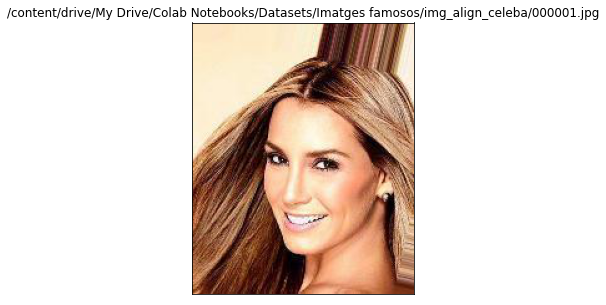

In [ ]:

img_file = Image.open(Path_image_test)

fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(img_file)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
axs.set_title(Path_image_test)

image_test = transform(Image.open(Path_image_test)).unsqueeze(0).to(device)

image_features = model.encode_image(image_test)
text_features = model.encode_text(image_text)
    
image_logits, image_logits_text = model(image_test, image_text)

N_probs=len(image_logits[0])

image_probs=image_logits.detach().numpy()[0]
image_probs_index=list(range(N_probs))

image_probs_order=np.zeros((N_probs,2))

image_probs_order[:,0]=np.sort(image_probs)[::-1]

for i in range(N_probs):
    data_saved=False
    j=0
    while not data_saved:
        if image_probs_order[i,0]==image_probs[image_probs_index[j]]:
            image_probs_order[i,1]=int(image_probs_index[j])
            image_probs_index.remove(image_probs_index[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nPrediccion:',candidate_captions[np.argmax(image_probs)])
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs):
    print('-',candidate_captions[np.int(image_probs_order[i,1])], '('+str(image_probs_order[i,0])+')')

print()

In [ ]:
print('\nPrediccion:',Descripciones[np.argmax(image_probs)])
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

for i in range(N_Labels):
    print('-',str(i+1).zfill(2), Descripciones[np.int(image_probs_order[i,1])],'('+str(image_probs_order[i,0])+')')

print()


Prediccion: Tiene el pelo rubio 
- 01 Tiene el pelo rubio  (26.991703033447266)
- 02 Tiene el pelo lacio  (26.9375057220459)
- 03 Tiene el pelo castaño  (26.69160270690918)
- 04 Tiene el pelo ondulado  (25.481571197509766)
- 05 Lleva aretes  (24.38874626159668)
- 06 Tinene las cejas arqueadas  (24.311857223510742)
- 07 Cara ovalada  (24.15695571899414)
- 08 Tiene los pómulos altos  (24.126047134399414)
- 09 Está sonriendo (23.959243774414062)
- 10 Nariz puntiaguda  (23.78211784362793)
- 11 Tiene las cejas espesas  (23.710674285888672)
- 12 Tiene el pelo canoso  (23.584508895874023)
- 13 patillas  (23.52505111694336)
- 14 Lleva anteojos (23.29448890686035)
- 15 Lleva sombrero  (23.213342666625977)
- 16 Es joven (23.170318603515625)
- 17 Lleva maquillaje pesado  (23.044414520263672)
- 18 Tiene los ojos estrechos (22.95871353149414)
- 19 Cada vez más calvo  (22.92298126220703)
- 20 Tiene la nariz grande  (22.815406799316406)
- 21 Lleva collar de uso  (22.798343658447266)
- 22 Tiene la bo

In [ ]:
model.save(BASE_FOLDER+'Model_Hair_All_v0.h5')
model.save('Model saved: Model_Hair_All_v0.h5')


In [ ]:
save_path = os.path.join(BASE_FOLDER,'Models/Model_Hair_All_v0/')
tf.saved_model.save(model, save_path)

In [ ]:
# for i in range(N_Labels):
#   if Description_data[0,i]:
#       print('Yes:',Description_labels[i])
      
#   else:
#       print('No:',Description_labels[i])


No: 5_o_Clock_Shadow
Yes: Arched_Eyebrows
Yes: Attractive
No: Bags_Under_Eyes
No: Bald
No: Bangs
No: Big_Lips
No: Big_Nose
No: Black_Hair
No: Blond_Hair
No: Blurry
Yes: Brown_Hair
No: Bushy_Eyebrows
No: Chubby
No: Double_Chin
No: Eyeglasses
No: Goatee
No: Gray_Hair
Yes: Heavy_Makeup
Yes: High_Cheekbones
No: Male
Yes: Mouth_Slightly_Open
No: Mustache
No: Narrow_Eyes
Yes: No_Beard
No: Oval_Face
No: Pale_Skin
Yes: Pointy_Nose
No: Receding_Hairline
No: Rosy_Cheeks
No: Sideburns
Yes: Smiling
Yes: Straight_Hair
No: Wavy_Hair
Yes: Wearing_Earrings
No: Wearing_Hat
Yes: Wearing_Lipstick
No: Wearing_Necklace
No: Wearing_Necktie
Yes: Young


# Celeba All 2

## Tokens

In [ ]:
# edit your prompts as you see fit here
%%writefile ./_tokenization2.txt
A face of a person with five o'clock shadow
A face of a person with arched eyebrows
A face of an attractive person
A face of a person with bags under the eyes
A face of a bald person
A face of a person who has bangs
A face of a person with big lips
A face of a person with big nose
A face of a person with black hair
A face of a blond person
A face of a blond man
A face of a blonde girl
A face of a man with blond hair
A face of a girl with blond hair
A face of a person with blond hair
A blurry face of a person
A face of a person with brown hair
A face of a person with bushy eyebrows
A face of a chubby person 
A face of a person with a double chin
A face of a person wearing eyeglasses 
A face of a person with goatee
A face of a person with gray hair
A face of a person wearing heavy makeup
A face of a person with high cheekbones
A face of a man
A face of a person a slightly open mouth
A face of a person with mustache
A face of a person with narrow eyes
A face of a person who does not wear a beard
A face of a person with an oval face
A face of a person wiht pale skin
A face of a person with pointy nose
A face of a person who is receding hairline
A face of a person with rosy cheeks
A face of a person with sideburns
A face of a person who is Smiling
A face of a person with straight hair
A face of a person with wavy hair
A face of a person wearing earrings
A face of a person wearing hat
A face of a person wearing lipstick
A face of a person with wearing necklace
A face of a person with Wearing necktie
A face of person who is young
A portrait of a person with five o'clock shadow
A portrait of a person with arched eyebrows
A portrait of an attractive person
A portrait of a person with bags under the eyes
A portrait of a bald person
A portrait of a person who has bangs
A portrait of a person with big lips
A portrait of a person with big nose
A portrait of a person with black hair
A portrait of a person with blond hair
A blurry portrait of a person
A portrait of a person with brown hair
A portrait of a person with bushy eyebrows
A portrait of a chubby person 
A portrait of a person with a double chin
A portrait of a person wearing eyeglasses 
A portrait of a person with goatee
A portrait of a person with gray hair
A portrait of a person wearing heavy makeup
A portrait of a person with high cheekbones
A portrait of a man
A portrait of a person a slightly open mouth
A portrait of a person with mustache
A portrait of a person with narrow eyes
A portrait of a person who does not wear a beard
A portrait of a person with an oval face
A portrait of a person wiht pale skin
A portrait of a person with pointy nose
A portrait of a person who is receding hairline
A portrait of a person with rosy cheeks
A portrait of a person with sideburns
A portrait of a person who is Smiling
A portrait of a person with straight hair
A portrait of a person with wavy hair
A portrait of a person wearing earrings
A portrait of a person wearing hat
A portrait of a person wearing lipstick
A portrait of a person with wearing necklace
A portrait of a person with Wearing necktie
A portrait of person who is young
A picture of a person with five o'clock shadow
A picture of a person with arched eyebrows
A picture of an attractive person
A picture of a person with bags under the eyes
A picture of a bald person
A picture of a person who has bangs
A picture of a person with big lips
A picture of a person with big nose
A picture of a person with black hair
A picture of a person with blond hair
A blurry picture of a person
A picture of a person with brown hair
A picture of a person with bushy eyebrows
A picture of a chubby person 
A picture of a person with a double chin
A picture of a person wearing eyeglasses 
A picture of a person with goatee
A picture of a person with gray hair
A picture of a person wearing heavy makeup
A picture of a person with high cheekbones
A picture of a man
A picture of a person a slightly open mouth
A picture of a person with mustache
A picture of a person with narrow eyes
A picture of a person who does not wear a beard
A picture of a person with an oval face
A picture of a person wiht pale skin
A picture of a person with pointy nose
A picture of a person who is receding hairline
A picture of a person with rosy cheeks
A picture of a person with sideburns
A picture of a person who is Smiling
A picture of a person with straight hair
A picture of a person with wavy hair
A picture of a person wearing earrings
A picture of a person wearing hat
A picture of a person wearing lipstick
A picture of a person with wearing necklace
A picture of a person with Wearing necktie
A picture of a person who is young
A picture of the face of a person with five o'clock shadow
A picture of the face of a person with arched eyebrows
A picture of the face of an attractive person
A picture of the face of a person with bags under the eyes
A picture of the face of a bald person
A picture of the face of a person who has bangs
A picture of the face of a person with big lips
A picture of the face of a person with big nose
A picture of the face of a person with black hair
A picture of the face of a person with blond hair
A blurry picture of the face of a person
A picture of the face of a person with brown hair
A picture of the face of a person with bushy eyebrows
A picture of the face of a chubby person 
A picture of the face of a person with a double chin
A picture of the face of a person wearing eyeglasses 
A picture of the face of a person with goatee
A picture of the face of a person with gray hair
A picture of the face of a person wearing heavy makeup
A picture of the face of a person with high cheekbones
A picture of the face of a man
A picture of the face of a person a slightly open mouth
A picture of the face of a person with mustache
A picture of the face of a person with narrow eyes
A picture of the face of a person who does not wear a beard
A picture of the face of a person with an oval face
A picture of the face of a person wiht pale skin
A picture of the face of a person with pointy nose
A picture of the face of a person who is receding hairline
A picture of the face of a person with rosy cheeks
A picture of the face of a person with sideburns
A picture of the face of a person who is Smiling
A picture of the face of a person with straight hair
A picture of the face of a person with wavy hair
A picture of the face of a person wearing earrings
A picture of the face of the face of a person wearing hat
A picture of the face of the face of a person wearing lipstick
A picture of the face of a person with wearing necklace
A picture of the face of a person with Wearing necktie
A picture of the face of a person who is young

Overwriting ./_tokenization2.txt


In [ ]:
candidate_captions2 = []
with open('./_tokenization2.txt') as f:
    candidate_captions2 = f.read().splitlines()
print(candidate_captions2)

["A face of a person with five o'clock shadow", 'A face of a person with arched eyebrows', 'A face of an attractive person', 'A face of a person with bags under the eyes', 'A face of a bald person', 'A face of a person who has bangs', 'A face of a person with big lips', 'A face of a person with big nose', 'A face of a person with black hair', 'A face of a blond person', 'A face of a blond man', 'A face of a blonde girl', 'A face of a man with blond hair', 'A face of a girl with blond hair', 'A face of a person with blond hair', 'A blurry face of a person', 'A face of a person with brown hair', 'A face of a person with bushy eyebrows', 'A face of a chubby person ', 'A face of a person with a double chin', 'A face of a person wearing eyeglasses ', 'A face of a person with goatee', 'A face of a person with gray hair', 'A face of a person wearing heavy makeup', 'A face of a person with high cheekbones', 'A face of a man', 'A face of a person a slightly open mouth', 'A face of a person with

## Run CLIP inference on your classification dataset

In [ ]:
import torch
import clip
from PIL import Image
import glob

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

Path_Images_dataset2 = BASE_FOLDER+ 'Datasets/Imatges famosos/img_align_celeba/'
class_names2=Descripciones

Path_image_test2= BASE_FOLDER+'Datasets/Imatges famosos/img_align_celeba/000001.jpg'

device2 = "cuda" if torch.cuda.is_available() else "cpu"
model2, transform2 = clip.load("ViT-B/32", device=device2)

image_text2 = clip.tokenize(candidate_captions2).to(device2)



Prediccion: A picture of a person with straight hair
- A picture of a person with straight hair (28.674789428710938)
- A picture of a person with brown hair (28.673952102661133)
- A picture of a person with wavy hair (28.299991607666016)
- A picture of a person with blond hair (28.231891632080078)
- A picture of a person with blond hair (28.231891632080078)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with brown hair (27.801395416259766)
- A picture of the face of a person with straight hair (27.560043334960938)
- A portrait of a person with straight hair (27.184791564941406)
- A face of a person with blond hair (26.9917049407959)
- A face of a person with straight hair (26.93750762939453)
- A picture of the face of a person with wavy hair (26.811420440673828)
- A face of a person with brown hair (26.691606521606445)
- A portrait of a person with wavy 

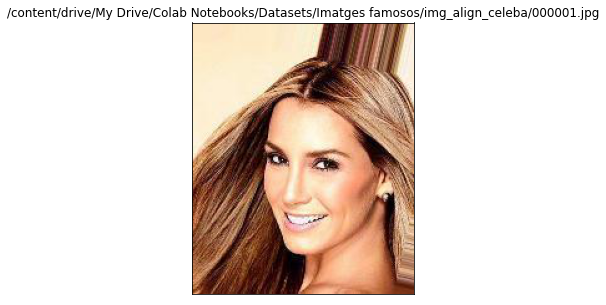

In [ ]:

img_file2 = Image.open(Path_image_test2)

fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(img_file2)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
axs.set_title(Path_image_test2)

image_test2 = transform2(Image.open(Path_image_test2)).unsqueeze(0).to(device2)

image_features2 = model2.encode_image(image_test2)
text_features2 = model2.encode_text(image_text2)
    
image_logits2, image_logits_text2 = model2(image_test2, image_text2)

N_probs2=len(image_logits2[0])

image_probs2=image_logits2.detach().numpy()[0]
image_probs_index2=list(range(N_probs2))

image_probs_order2=np.zeros((N_probs2,2))

image_probs_order2[:,0]=np.sort(image_probs2)[::-1]

for i in range(N_probs2):
    data_saved=False
    j=0
    while not data_saved:
        # print(i,j,image_probs_index2[j],image_probs_order2[i,0],image_probs2[image_probs_index2[j]])
        if image_probs_order2[i,0]==image_probs2[image_probs_index2[j]]:
            image_probs_order2[i,1]=np.int(image_probs_index2[j])
            image_probs_index2.remove(image_probs_index2[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nPrediccion:',candidate_captions2[np.argmax(image_probs2)])
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs2):
    print('-',candidate_captions2[np.int(image_probs_order2[i,1])], '('+str(image_probs_order2[i,0])+')')

print()


Prediccion: A picture of a person with brown hair
- A picture of a person with brown hair (27.02178955078125)
- A picture of a person with arched eyebrows (27.000925064086914)
- A picture of a person with pointy nose (26.812345504760742)
- A picture of the face of a person wiht pale skin (26.598960876464844)
- A picture of a person with narrow eyes (26.47034454345703)
- A picture of a person with an oval face (26.407026290893555)
- A picture of a person who is Smiling (26.39948081970215)
- A picture of the face of a person with arched eyebrows (26.37786865234375)
- A picture of a person wearing earrings (26.34112548828125)
- A picture of the face of a person with narrow eyes (26.26568031311035)
- A face of a person wiht pale skin (26.201217651367188)
- A picture of a person who is young (26.169231414794922)
- A picture of the face of a person with blond hair (26.139039993286133)
- A picture of the face of a person with blond hair (26.139039993286133)
- A picture of a person with bags 

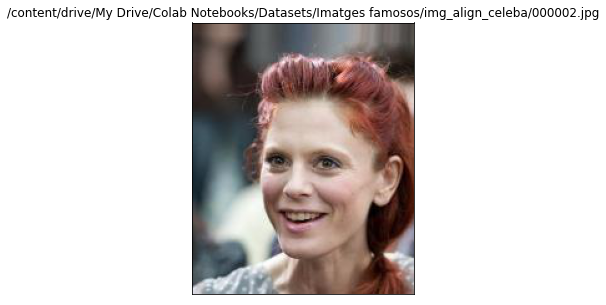

In [ ]:

Path_image_test2= BASE_FOLDER+'Datasets/Imatges famosos/img_align_celeba/000002.jpg'

img_file2 = Image.open(Path_image_test2)

fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(img_file2)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
axs.set_title(Path_image_test2)

image_test2 = transform2(Image.open(Path_image_test2)).unsqueeze(0).to(device2)

image_features2 = model2.encode_image(image_test2)
text_features2 = model2.encode_text(image_text2)
    
image_logits2, image_logits_text2 = model2(image_test2, image_text2)

N_probs2=len(image_logits2[0])

image_probs2=image_logits2.detach().numpy()[0]
image_probs_index2=list(range(N_probs2))

image_probs_order2=np.zeros((N_probs2,2))

image_probs_order2[:,0]=np.sort(image_probs2)[::-1]

for i in range(N_probs2):
    data_saved=False
    j=0
    while not data_saved:
        # print(i,j,image_probs_index2[j],image_probs_order2[i,0],image_probs2[image_probs_index2[j]])
        if image_probs_order2[i,0]==image_probs2[image_probs_index2[j]]:
            image_probs_order2[i,1]=np.int(image_probs_index2[j])
            image_probs_index2.remove(image_probs_index2[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nPrediccion:',candidate_captions2[np.argmax(image_probs2)])
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs2):
    print('-',candidate_captions2[np.int(image_probs_order2[i,1])], '('+str(image_probs_order2[i,0])+')')

print()

In [ ]:

N_probs2=len(image_logits2[0])

image_probs2=image_logits2.detach().numpy()[0]
image_probs_index2=list(range(N_probs2))

image_probs_order2=np.zeros((N_probs2,2))

image_probs_order2[:,0]=np.sort(image_probs2)[::-1]

for i in range(N_probs2):
    data_saved=False
    j=0
    while not data_saved:
        # print(i,j,image_probs_index2[j],image_probs_order2[i,0],image_probs2[image_probs_index2[j]])
        if image_probs_order2[i,0]==image_probs2[image_probs_index2[j]]:
            image_probs_order2[i,1]=np.int(image_probs_index2[j])
            image_probs_index2.remove(image_probs_index2[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nPrediccion:',candidate_captions2[np.argmax(image_probs2)])
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs2):
    print('-',candidate_captions2[np.int(image_probs_order2[i,1])], '('+str(image_probs_order2[i,0])+')')


Prediccion: A picture of a person with straight hair
- A picture of a person with straight hair (28.674789428710938)
- A picture of a person with brown hair (28.673952102661133)
- A picture of a person with wavy hair (28.299991607666016)
- A picture of a person with blond hair (28.231891632080078)
- A picture of a person with blond hair (28.231891632080078)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with brown hair (27.801395416259766)
- A picture of the face of a person with straight hair (27.560043334960938)
- A portrait of a person with straight hair (27.184791564941406)
- A face of a person with blond hair (26.9917049407959)
- A face of a person with straight hair (26.93750762939453)
- A picture of the face of a person with wavy hair (26.811420440673828)
- A face of a person with brown hair (26.691606521606445)
- A portrait of a person with wavy 

In [ ]:
model2.save(BASE_FOLDER+'Model_2_All_v0.h5')
model2.save('Model saved: Model_2_All_v0.h5')


In [ ]:
save_path2 = os.path.join(BASE_FOLDER,'Models/Model_2_All_v0/')
tf.saved_model.save(model2, save_path2)

## Ejemplos


Prediccion: A picture of a person with straight hair
- A picture of a person with straight hair (28.674789428710938)
- A picture of a person with brown hair (28.673952102661133)
- A picture of a person with wavy hair (28.299991607666016)
- A picture of a person with blond hair (28.231891632080078)
- A picture of a person with blond hair (28.231891632080078)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with blond hair (28.09806251525879)
- A picture of the face of a person with brown hair (27.801395416259766)
- A picture of the face of a person with straight hair (27.560043334960938)
- A portrait of a person with straight hair (27.184791564941406)
- A face of a person with blond hair (26.9917049407959)
- A face of a person with straight hair (26.93750762939453)
- A picture of the face of a person with wavy hair (26.811420440673828)
- A face of a person with brown hair (26.691606521606445)
- A portrait of a person with wavy 


Prediccion: A picture of a person with straight hair
- A picture of a person with straight hair (28.674789428710938)
- A picture of a person with brown hair (28.673952102661133)
- A picture of a person with wavy hair (28.299991607666016)
- A picture of a person with blond hair (28.231891632080078)
- A picture of a person with blond hair (28.231891632080078)
- A portrait of a person with straight hair (27.184791564941406)
- A face of a person with blond hair (26.9917049407959)
- A face of a person with straight hair (26.93750762939453)
- A face of a person with brown hair (26.691606521606445)
- A portrait of a person with wavy hair (26.41604232788086)
- A portrait of a person with blond hair (26.24808120727539)
- A portrait of a person with blond hair (26.24808120727539)
- A portrait of a person with brown hair (26.223175048828125)
- A picture of a person with high cheekbones (26.11892318725586)
- A picture of a person with arched eyebrows (25.735023498535156)
- A face of a girl with b

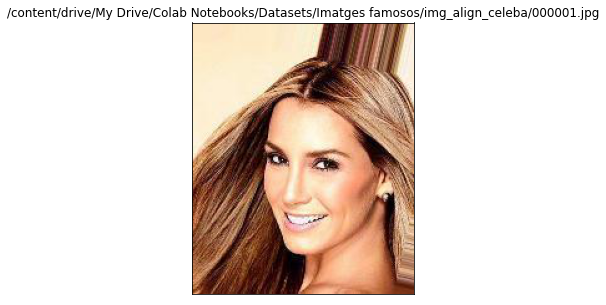

# Celeba All 3

## Tokens

In [ ]:
# edit your prompts as you see fit here
%%writefile ./_tokenization2.txt
A picture of a person with five o'clock shadow
A picture of a person with goatee
A picture of a person with mustache
A picture of a person who does not wear a beard
A picture of a person with beard
A picture of a person with arched eyebrows
A picture of a person with straight eyebrows
A picture of a person with bushy eyebrows
A photo of a person with normal eyebrows
A photo of a person with thin eyebrows
A picture of an attractive person
A picture of an unattractive person
A picture of a person with bags under the eyes
A picture of a person without bags under the eyes
A picture of a bald person
A picture of a person who is receding hairline
A picture of a person with hair
A picture of a person with black hair
A picture of a person with blond hair
A picture of a person with brown hair
A picture of a person with red hair
A picture of a person with gray hair
A picture of a person with colored hair
A picture of a person with straight hair
A picture of a person with wavy hair
A picture of a girl with hair
A picture of a girl with black hair
A picture of a girl with blond hair
A picture of a girl with brown hair
A picture of a girl with red hair
A picture of a girl with gray hair
A picture of a girl with colored hair
A picture of a girl with straight hair
A picture of a girl with wavy hair
A picture of a woman with hair
A picture of a woman with black hair
A picture of a woman with blond hair
A picture of a woman with brown hair
A picture of a woman with red hair
A picture of a woman with gray hair
A picture of a woman with colored hair
A picture of a woman with straight hair
A picture of a woman with wavy hair
A picture of a man with hair
A picture of a man with black hair
A picture of a man with blond hair
A picture of a man with brown hair
A picture of a man with red hair
A picture of a man with gray hair
A picture of a man with colored hair
A picture of a man with straight hair
A picture of a man with wavy hair
A picture of a person who has bangs
A picture of a person who not has bangs
A picture of a person with big lips
A picture of a person with small lips
A picture of a person with big nose
A picture of a person with small nose
A blurry picture of a person
A focused picture of a person
A picture of a chubby person 
A picture of a thin person 
A picture of a handsome person 
A picture of a person with a double chin
A picture of a person without a double chin
A picture of a person wearing eyeglasses 
A picture of a person not wearing eyeglasses 
A picture of a person wearing heavy makeup
A picture of a person not wearing heavy makeup
A picture of a person with high cheekbones
A picture of a person without high cheekbones
A picture of a man
A picture of a male
A picture of a woman
A picture of a female
A picture of a boy
A picture of a girl
A picture of a child
A picture of a old person
A picture of a mature person
A picture of a young person
A picture of a person a slightly open mouth
A picture of a person with closed mouth
A picture of a person with narrow eyes
A picture of a person with opened eyes
A picture of a person with an oval face
A picture of a person with an round face
A picture of a person with an square face
A picture of a person wiht pale skin
A picture of a person wiht colorful skin
A picture of a person wiht dark skin
A picture of a person with rosy cheeks
A picture of a person without rosy cheeks
A picture of a person with pointy nose
A picture of a person without pointy nose
A picture of a person with sideburns
A picture of a person without sideburns
A picture of a person who is smiling
A picture of a person who is not smiling
A picture of a person with earrings
A picture of a person without wearing earrings
A picture of a person wearing a hat
A picture of a person not wearing a hat
A picture of a person with lipstick
A picture of a person without lipstick
A picture of a person wearing a necklace
A picture of a person not wearing a necklace
A picture of a person with necktie
A picture of a person without necktie

Overwriting ./_tokenization2.txt


In [ ]:
candidate_captions2 = []
with open('./_tokenization2.txt') as f:
    candidate_captions2 = f.read().splitlines()
print(candidate_captions2)

["A picture of a person with five o'clock shadow", 'A picture of a person with goatee', 'A picture of a person with mustache', 'A picture of a person who does not wear a beard', 'A picture of a person with beard', 'A picture of a person with arched eyebrows', 'A picture of a person with straight eyebrows', 'A picture of a person with bushy eyebrows', 'A photo of a person with normal eyebrows', 'A photo of a person with thin eyebrows', 'A picture of an attractive person', 'A picture of an unattractive person', 'A picture of a person with bags under the eyes', 'A picture of a person without bags under the eyes', 'A picture of a bald person', 'A picture of a person who is receding hairline', 'A picture of a person with hair', 'A picture of a person with black hair', 'A picture of a person with blond hair', 'A picture of a person with brown hair', 'A picture of a person with red hair', 'A picture of a person with gray hair', 'A picture of a person with colored hair', 'A picture of a person

## Run CLIP inference on your classification dataset

In [ ]:
import torch
import clip
from PIL import Image
import glob

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

Path_Images_dataset2 = BASE_FOLDER+ 'Datasets/Imatges famosos/img_align_celeba/'
class_names2=Descripciones

device2 = "cuda" if torch.cuda.is_available() else "cpu"
model2, transform2 = clip.load("ViT-B/32", device=device2)

image_text2 = clip.tokenize(candidate_captions2).to(device2)



Atributos reales:
This person fulfills that:
 -> Arched_Eyebrows,Attractive,Brown_Hair,Heavy_Makeup,High_Cheekbones,Mouth_Slightly_Open,No_Beard,Pointy_Nose,Smiling,Straight_Hair,Wearing_Earrings,Wearing_Lipstick,Young
This person no fulfills that:
 -> 5_o_Clock_Shadow,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Male,Mustache,Narrow_Eyes,Oval_Face,Pale_Skin,Receding_Hairline,Rosy_Cheeks,Sideburns,Wavy_Hair,Wearing_Hat,Wearing_Necklace,Wearing_Necktie


Prediccion: A picture of a woman with straight hair

- A picture of a woman with straight hair (0.17363114655017853)
- A picture of a person with straight hair (0.1251606047153473)
- A picture of a person with brown hair (0.12505586445331573)
- A picture of a woman with wavy hair (0.08808265626430511)
- A picture of a person with wavy hair (0.08603894710540771)
- A picture of a person with blond hair (0.08037475496530533)
- A picture of a woman w

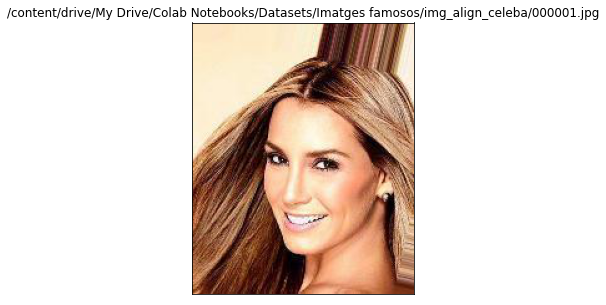

In [ ]:
selected_index=1
Path_image_test2= BASE_FOLDER+'Datasets/Imatges famosos/img_align_celeba/'+str(selected_index).zfill(6)+'.jpg'

img_file2 = Image.open(Path_image_test2)

fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(img_file2)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
axs.set_title(Path_image_test2)

image_test2 = transform2(Image.open(Path_image_test2)).unsqueeze(0).to(device2)

image_features2 = model2.encode_image(image_test2)
text_features2 = model2.encode_text(image_text2)
    
image_logits2, image_logits_text2 = model2(image_test2, image_text2)

N_probs2=len(image_logits2[0])

image_probs2=softmax(image_logits2.detach().numpy()[0])
image_probs_index2=list(range(N_probs2))

image_probs_order2=np.zeros((N_probs2,2))

image_probs_order2[:,0]=np.sort(image_probs2)[::-1]

for i in range(N_probs2):
    data_saved=False
    j=0
    while not data_saved:
        # print(i,j,image_probs_index2[j],image_probs_order2[i,0],image_probs2[image_probs_index2[j]])
        if image_probs_order2[i,0]==image_probs2[image_probs_index2[j]]:
            image_probs_order2[i,1]=np.int(image_probs_index2[j])
            image_probs_index2.remove(image_probs_index2[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nAtributos reales:')
Atributos_Reales(selected_index, N_Labels,Description_labels)
print() # mejor visualizacion

print('\nPrediccion:',candidate_captions2[np.argmax(image_probs2)])
print() # mejor visualizacion
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs2):
    print('-',candidate_captions2[np.int(image_probs_order2[i,1])], '('+str(image_probs_order2[i,0])+')')

print()


Atributos reales:
This person fulfills that:
 -> Bags_Under_Eyes,Big_Nose,Brown_Hair,High_Cheekbones,Mouth_Slightly_Open,No_Beard,Smiling,Young
This person no fulfills that:
 -> 5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bald,Bangs,Big_Lips,Black_Hair,Blond_Hair,Blurry,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,Male,Mustache,Narrow_Eyes,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie


Prediccion: A picture of a person with red hair

- A picture of a person with red hair (0.5012649893760681)
- A picture of a woman with red hair (0.2760207951068878)
- A picture of a person with colored hair (0.06322503089904785)
- A picture of a woman with colored hair (0.03774503991007805)
- A picture of a girl with red hair (0.02872553840279579)
- A photo of a person with normal eyebrows (0.005593715701252222)
- A picture of a girl with colore

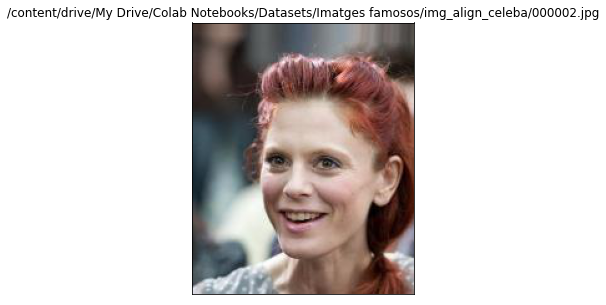

In [ ]:
selected_index=2
Path_image_test2= BASE_FOLDER+'Datasets/Imatges famosos/img_align_celeba/'+str(selected_index).zfill(6)+'.jpg'

img_file2 = Image.open(Path_image_test2)

fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(img_file2)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
axs.set_title(Path_image_test2)

image_test2 = transform2(Image.open(Path_image_test2)).unsqueeze(0).to(device2)

image_features2 = model2.encode_image(image_test2)
text_features2 = model2.encode_text(image_text2)
    
image_logits2, image_logits_text2 = model2(image_test2, image_text2)

N_probs2=len(image_logits2[0])

image_probs2=softmax(image_logits2.detach().numpy()[0])
image_probs_index2=list(range(N_probs2))

image_probs_order2=np.zeros((N_probs2,2))

image_probs_order2[:,0]=np.sort(image_probs2)[::-1]

for i in range(N_probs2):
    data_saved=False
    j=0
    while not data_saved:
        # print(i,j,image_probs_index2[j],image_probs_order2[i,0],image_probs2[image_probs_index2[j]])
        if image_probs_order2[i,0]==image_probs2[image_probs_index2[j]]:
            image_probs_order2[i,1]=np.int(image_probs_index2[j])
            image_probs_index2.remove(image_probs_index2[j])
            data_saved=True
        else:
            j+=1

# print('\nFeatures:',image_features)
# print('\nText Features:',image_features)
# print('\nLogits:',image_logits)
# print('\nLogits per text:',image_logits_text)

print('\nAtributos reales:')
Atributos_Reales(selected_index, N_Labels,Description_labels)
print() # mejor visualizacion

print('\nPrediccion:',candidate_captions2[np.argmax(image_probs2)])
print() # mejor visualizacion
# print('\nPredicciones:',image_probs)
# print('\nPredicciones ordenadas:',image_probs_order)

# print tokens
for i in range(N_probs2):
    print('-',candidate_captions2[np.int(image_probs_order2[i,1])], '('+str(image_probs_order2[i,0])+')')

print()

In [ ]:
model2.save(BASE_FOLDER+'Model_2_All_v0.h5')
model2.save('Model saved: Model_2_All_v0.h5')


In [ ]:
save_path2 = os.path.join(BASE_FOLDER,'Models/Model_2_All_v0/')
tf.saved_model.save(model2, save_path2)

## Ejemplos